In [20]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "matplotlib"
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
import numpy.random as npr
import scipy.optimize as sco
import scipy.interpolate as spi
import math

------------------

# Process data file

In [21]:
def process_data(file):
    df = pd.read_csv(file, header=None)
    df.columns = pd.MultiIndex.from_arrays([df.iloc[0], df.iloc[1]])
    df = df.drop([0,1]) 
    df = df.reset_index(drop=True)
    df.dropna(inplace=True)
    df = df.set_index(df.columns[0])
    df.index.name = 'Date'
    for col in df.columns:
        df[col] = df[col].astype(float)
    close_df = df['Close']
    close_df.index = pd.to_datetime(close_df.index, dayfirst=True)

    return close_df


-----------------------

# Models and benchmarking

In [22]:

def SMA(stocks, close_df, period_short=30, period_long=50, start_date = '2024-03-01'):
    close_df = close_df.copy()
    close_df = close_df[stocks]
    sma_short = close_df.rolling(window=period_short).mean()
    sma_long  = close_df.rolling(window=period_long).mean()

    # Generate signals:
    #   1  => SMA short < SMA long (bullish)
    #  -0.5  => SMA short > SMA long (bearish)
    signal = (sma_short < sma_long).astype(int).replace(0, -0.5)
    signal.loc[signal.index < start_date] = 0

    # Daily returns from close prices
    daily_ret = close_df.pct_change()

    # Strategy return = signal * daily return
    strategy_ret = signal.shift(1) * daily_ret

    # Cumulative returns    
    cumulative_ret = (1 + strategy_ret.fillna(0)).cumprod()
    cumulative_ret = cumulative_ret.loc[cumulative_ret.index >= start_date]
    signal = signal.loc[signal.index >= start_date]
    return cumulative_ret, signal

def rolling_regression_predicted_returns(df,stocks, lags=[1, 2, 3], start_date='2024-03-01'):
    
    df = df.loc[:, stocks]
    df = np.log(df/df.shift(1)).dropna()
    predicted_returns = pd.DataFrame(index=df.index, columns=df.columns)
    signal_df = pd.DataFrame(index=df.index, columns=df.columns)

    # Convert start_date to datetime and find the index where it occurs
    start_date = pd.to_datetime(start_date)
    start_index = df.index.get_indexer([start_date], method='ffill')[0]

    # Determine the rolling window size as the length of rows before the start date
    window = start_index  # This will be the number of rows before start_date



    for col in df.columns:
        series = df[col]

        # Create lagged features
        lagged_data = pd.concat([series.shift(lag) for lag in lags], axis=1)
        lagged_data.columns = [f'{col}_lag{lag}' for lag in lags]

        # Combine features and target
        full_data = pd.concat([series, lagged_data], axis=1).dropna()
        start_index = full_data.index.get_indexer([start_date], method='ffill')[0]

        # Determine the rolling window size as the length of rows before the start date
        window = start_index  # This will be the number of rows before start_date

        for i in range(window, len(full_data)):
            window_data = full_data.iloc[i - window:i]
            X = window_data[[f'{col}_lag{lag}' for lag in lags]]
            y = window_data[col]

            model = LinearRegression()
            model.fit(X, y)

            current_features = full_data.iloc[i][[f'{col}_lag{lag}' for lag in lags]].to_frame().T
            pred_index = full_data.index[i]
            pred = model.predict(current_features)[0]

            # Convert prediction to trading signal: 1 or -1
            signal = 1 if pred > 0 else -0.5
            signal_df.loc[pred_index, col] = signal

            # Multiply signal with actual log return to get predicted returns
            predicted_returns.loc[pred_index, col] = signal * df.loc[pred_index, col]

    # Filter by start_date
    predicted_returns = predicted_returns[predicted_returns.index >= pd.to_datetime(start_date)]
    signal_df = signal_df[signal_df.index >= start_date]

    predicted_returns.iloc[0] = 0.0
    predicted_returns += 1.0
    predicted_returns = predicted_returns.cumprod()
    
    return predicted_returns.astype(float), signal_df.astype(float)

def rolling_DTclassification_predicted_returns(df,stocks, lags=[1, 2, 3], start_date='2024-03-01'):
    
    df = df.loc[:, stocks]
    df = np.log(df/df.shift(1)).dropna()
    predicted_returns = pd.DataFrame(index=df.index, columns=df.columns)
    signal_df = pd.DataFrame(index=df.index, columns=df.columns)

    start_date = pd.to_datetime(start_date)
    start_index = df.index.get_indexer([start_date], method='ffill')[0]
    window = start_index  # Window size is the number of rows before start_date

    for col in df.columns:
        series = df[col]

        # Create lagged features
        lagged_data = pd.concat([series.shift(lag) for lag in lags], axis=1)
        lagged_data.columns = [f'{col}_lag{lag}' for lag in lags]

        # Combine features and target
        full_data = pd.concat([series, lagged_data], axis=1).dropna()
        start_index = full_data.index.get_indexer([start_date], method='ffill')[0]

        # Determine the rolling window size as the length of rows before the start date
        window = start_index  # This will be the number of rows before start_date
        
        # Create the target: 1 if return is positive, -1 if return is negative
        target = np.where(full_data[col] > 0, 1, -1)  # Binary target for classification

        for i in range(window, len(full_data)):
            window_data = full_data.iloc[i - window:i]
            X = window_data[[f'{col}_lag{lag}' for lag in lags]]
            y = target[i - window:i]  # Use binary target for classification

            # Using DecisionTreeClassifier
            model = DecisionTreeClassifier(max_depth = 5, random_state = 100)
            model.fit(X, y)

            current_features = full_data.iloc[i][[f'{col}_lag{lag}' for lag in lags]].to_frame().T
            pred_index = full_data.index[i]
            pred = model.predict(current_features)[0]
            signal = {1: 1, -1: -0.5}.get(pred, 0)
            signal_df.loc[pred_index, col] = signal

            # Multiply signal with actual log return to get predicted returns
            predicted_returns.loc[pred_index, col] = signal  * df.loc[pred_index, col]

    # Filter by start_date
    predicted_returns = predicted_returns[predicted_returns.index >= pd.to_datetime(start_date)]
    signal_df = signal_df[signal_df.index >= start_date]
    
    predicted_returns.iloc[0] = 0.0
    predicted_returns += 1.0
    predicted_returns = predicted_returns.cumprod()
    
    return predicted_returns.astype(float), signal_df.astype(float)

def rolling_svc_predicted_returns(df,stocks, lags=[1, 2, 3], start_date='2024-03-01'):
    
    df = df.loc[:, stocks]
    df = np.log(df/df.shift(1)).dropna()
    predicted_returns = pd.DataFrame(index=df.index, columns=df.columns)
    signal_df = pd.DataFrame(index=df.index, columns=df.columns)

    start_date = pd.to_datetime(start_date)
    start_index = df.index.get_indexer([start_date], method='ffill')[0]
    window = start_index  # Use all data before the start_date

    for col in df.columns:
        series = df[col]

        # Create lagged features
        lagged_data = pd.concat([series.shift(lag) for lag in lags], axis=1)
        lagged_data.columns = [f'{col}_lag{lag}' for lag in lags]

        # Combine features and target
        full_data = pd.concat([series, lagged_data], axis=1).dropna()
        start_index = full_data.index.get_indexer([start_date], method='ffill')[0]

        # Determine the rolling window size as the length of rows before the start date
        window = start_index  # This will be the number of rows before start_date
        
        # Binary target: 1 for up, -1 for down
        target = np.where(full_data[col] > 0, 1, -1)

        for i in range(window, len(full_data)):
            window_data = full_data.iloc[i - window:i]
            X = window_data[[f'{col}_lag{lag}' for lag in lags]]
            y = target[i - window:i]

            # Logistic Regression model
            model = SVC(kernel='linear')
            model.fit(X, y)

            current_features = full_data.iloc[i][[f'{col}_lag{lag}' for lag in lags]].to_frame().T
            pred_index = full_data.index[i]
            pred = model.predict(current_features)[0]
            signal = {1: 1, -1: -0.5}.get(pred, 0)
            signal_df.loc[pred_index, col] = signal

            # Multiply signal with actual log return to get predicted returns
            predicted_returns.loc[pred_index, col] = signal  * df.loc[pred_index, col]

    # Keep only rows after start_date
    predicted_returns = predicted_returns[predicted_returns.index >= pd.to_datetime(start_date)]
    signal_df = signal_df[signal_df.index >= start_date]

    predicted_returns.iloc[0] = 0.0
    predicted_returns += 1.0
    predicted_returns = predicted_returns.cumprod()

    return predicted_returns.astype(float), signal_df.astype(float)

def get_benchmark(stocks, close_df, start_date):
    close_df = close_df.copy()
    close_df = close_df[stocks]
    daily_ret = close_df.pct_change()
    cumulative_ret = (1 + daily_ret.fillna(0)).cumprod()
    cumulative_ret = cumulative_ret.loc[cumulative_ret.index >= start_date]

    return cumulative_ret

#Below are functions for training 
def LR_Training_Rolling_Returns(df, lags=[1, 2], start_date='2024-02-01'):
    predicted_returns = pd.DataFrame(index=df.index, columns=df.columns)

    # Convert start_date to datetime and find the index where it occurs
    start_date = pd.to_datetime(start_date)
    start_index = df.index.get_indexer([start_date], method='ffill')[0]

    # Determine the rolling window size as the length of rows before the start date
    window = start_index  # This will be the number of rows before start_date

    for col in df.columns:
        series = df[col]

        # Create lagged features
        lagged_data = pd.concat([series.shift(lag) for lag in lags], axis=1)
        lagged_data.columns = [f'{col}_lag{lag}' for lag in lags]

        # Combine features and target
        full_data = pd.concat([series, lagged_data], axis=1).dropna()
        start_index = full_data.index.get_indexer([start_date], method='ffill')[0]

        # Determine the rolling window size as the length of rows before the start date
        window = start_index  # This will be the number of rows before start_date

        for i in range(window, len(full_data)):
            window_data = full_data.iloc[i - window:i]
            X = window_data[[f'{col}_lag{lag}' for lag in lags]]
            y = window_data[col]

            model = LinearRegression()
            model.fit(X, y)

            current_features = full_data.iloc[i][[f'{col}_lag{lag}' for lag in lags]].to_frame().T
            pred_index = full_data.index[i]
            pred = model.predict(current_features)[0]

            # Convert prediction to trading signal: 1 or -1
            signal = 1 if pred > 0 else -0.5

            # Multiply signal with actual log return to get predicted returns
            predicted_returns.loc[pred_index, col] = signal * df.loc[pred_index, col]

    # Filter by start_date
    predicted_returns = predicted_returns[predicted_returns.index >= pd.to_datetime(start_date)]

    return predicted_returns.astype(float)

def DT_Training_Rolling_Returns(df, lags=[1, 2], start_date='2024-02-01'):
    predicted_returns = pd.DataFrame(index=df.index, columns=df.columns)

    start_date = pd.to_datetime(start_date)
    start_index = df.index.get_indexer([start_date], method='ffill')[0]
    window = start_index  # Window size is the number of rows before start_date

    for col in df.columns:
        series = df[col]

        # Create lagged features
        lagged_data = pd.concat([series.shift(lag) for lag in lags], axis=1)
        lagged_data.columns = [f'{col}_lag{lag}' for lag in lags]

        # Combine features and target
        full_data = pd.concat([series, lagged_data], axis=1).dropna()
        start_index = full_data.index.get_indexer([start_date], method='ffill')[0]

        # Determine the rolling window size as the length of rows before the start date
        window = start_index  # This will be the number of rows before start_date
        
        # Create the target: 1 if return is positive, -1 if return is negative
        target = np.where(full_data[col] > 0, 1, -1)  # Binary target for classification

        for i in range(window, len(full_data)):
            window_data = full_data.iloc[i - window:i]
            X = window_data[[f'{col}_lag{lag}' for lag in lags]]
            y = target[i - window:i]  # Use binary target for classification

            # Using DecisionTreeClassifier
            model = DecisionTreeClassifier(max_depth = 3, random_state = 100)
            model.fit(X, y)

            current_features = full_data.iloc[i][[f'{col}_lag{lag}' for lag in lags]].to_frame().T
            pred_index = full_data.index[i]
            pred = model.predict(current_features)[0]
            pred = {1: 1, -1: -0.5}.get(pred, 0)

            # Multiply signal with actual log return to get predicted returns
            predicted_returns.loc[pred_index, col] = pred * df.loc[pred_index, col]

    # Filter by start_date
    predicted_returns = predicted_returns[predicted_returns.index >= pd.to_datetime(start_date)]

    return predicted_returns.astype(float)

def SVC_Training_Rolling_Returns(df, lags=[1, 2], start_date='2024-02-01'):
    predicted_returns = pd.DataFrame(index=df.index, columns=df.columns)

    start_date = pd.to_datetime(start_date)
    start_index = df.index.get_indexer([start_date], method='ffill')[0]
    window = start_index  # Use all data before the start_date as training window

    for col in df.columns:
        series = df[col]

        # Create lagged features
        lagged_data = pd.concat([series.shift(lag) for lag in lags], axis=1)
        lagged_data.columns = [f'{col}_lag{lag}' for lag in lags]

        # Combine features and target
        full_data = pd.concat([series, lagged_data], axis=1).dropna()
        start_index = full_data.index.get_indexer([start_date], method='ffill')[0]

        # Determine the rolling window size as the length of rows before the start date
        window = start_index  # This will be the number of rows before start_date
        
        # Create binary classification target
        target = np.where(full_data[col] > 0, 1, -1)

        for i in range(window, len(full_data)):
            window_data = full_data.iloc[i - window:i]
            X = window_data[[f'{col}_lag{lag}' for lag in lags]]
            y = target[i - window:i]

            model = SVC(kernel='linear')
            model.fit(X, y)

            current_features = full_data.iloc[i][[f'{col}_lag{lag}' for lag in lags]].to_frame().T
            pred_index = full_data.index[i]
            pred = model.predict(current_features)[0]
            pred = {1: 1, -1: -0.5}.get(pred, 0)

            # Predicted return = signal * actual return
            predicted_returns.loc[pred_index, col] = pred * df.loc[pred_index, col]

    # Filter rows after the start_date
    predicted_returns = predicted_returns[predicted_returns.index >= pd.to_datetime(start_date)]

    return predicted_returns.astype(float)

def Training_benchmark(df, start_date='2024-02-01'):

    # Convert start_date to datetime
    start_date = pd.to_datetime(start_date)

    # Filter the data from the start_date to the end of the dataset
    filtered_data = df[df.index >= start_date]

    # Sum the returns for each column from start_date to the end
    filtered_data.iloc[0] = 0.0
    filtered_data += 1.0
    column_sums = filtered_data.prod()


    # Apply np.exp to the sum of each column's returns

    return column_sums

def Training_Sum_returns(predicted_returns):
    # Sum each column of the predicted returns DataFrame

    
    # Apply np.exp to the sum of each column
    predicted_returns.iloc[0] = 0.0
    predicted_returns += 1.0
    column_sums = predicted_returns.prod()
    
    return column_sums




-------------------

# Training period data

We used downloaded data from Yahoo Finance from a period of 2023-01-01 to 2024-03-01 for training and stock selection

In [23]:
import yfinance as yf

# List of tickers
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA',
    'JNJ', 'PFE', 'UNH', 'XOM', 'CVX',
    'JPM', 'GS', 'AMZN', 'WMT', 'MCD',
    'KO', 'NKE', 'BA', 'CAT', 'SOFI'
]

# Download daily data (you can adjust the date range)
data = yf.download(tickers, start="2023-01-01", end="2024-03-01", interval='1d')

# Extract only the daily Close prices
close_prices = data['Close']

[*********************100%***********************]  20 of 20 completed


10 stocks were chosen for analysis using SMA and the better performing stocks were selected.
Stocks were also ran through different models to determine the top performing stocks according to the strategies

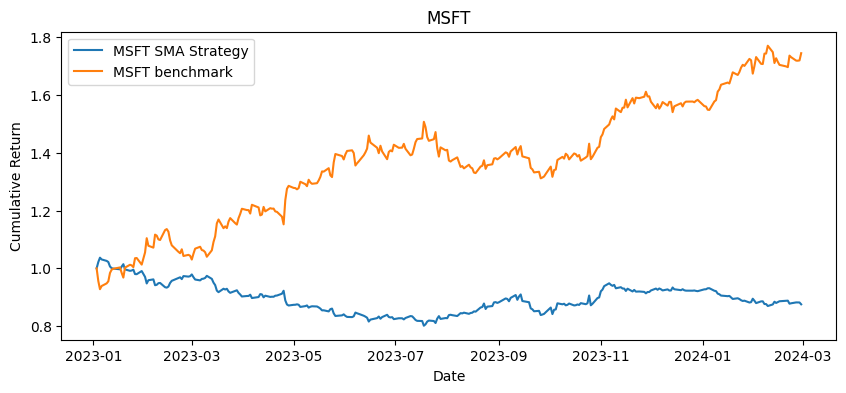

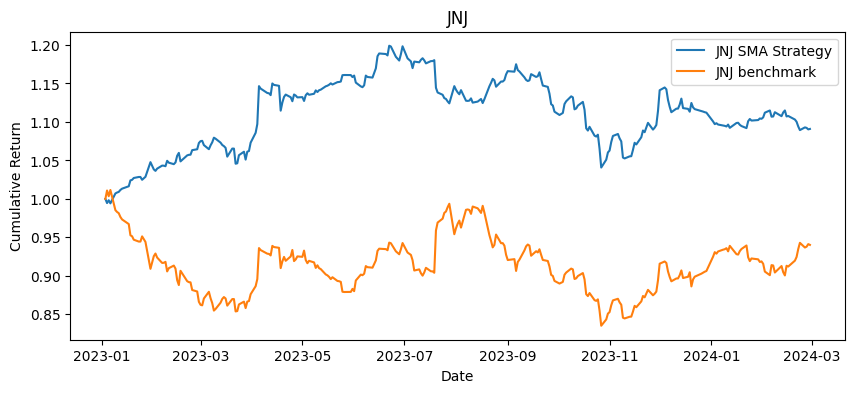

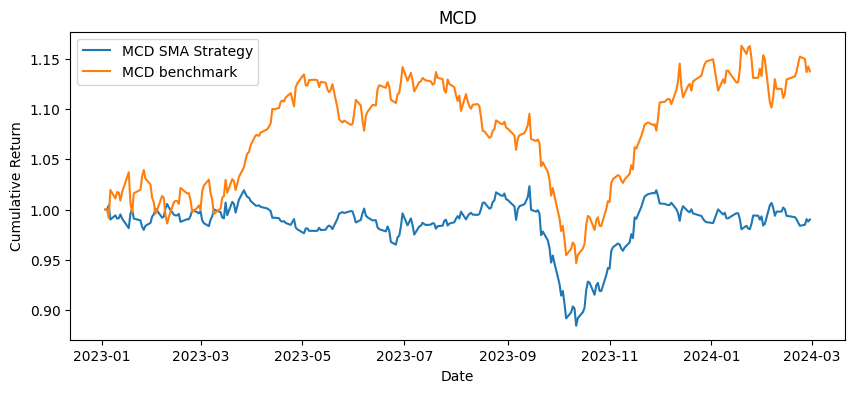

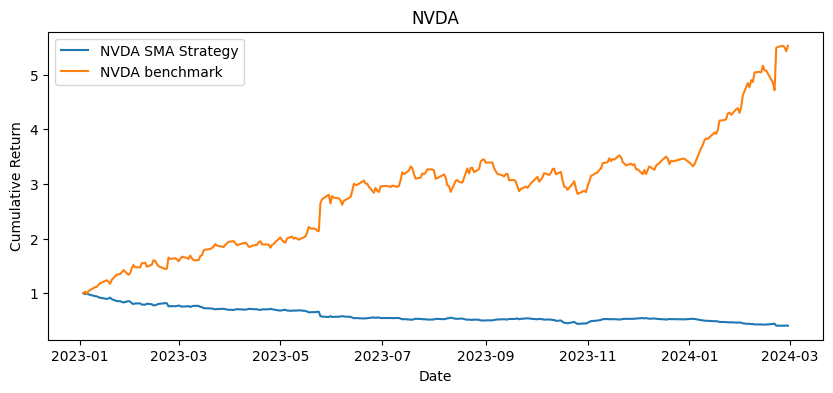

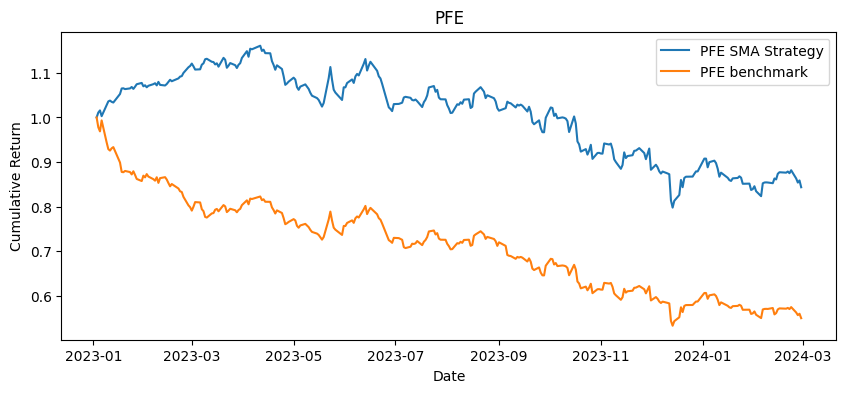

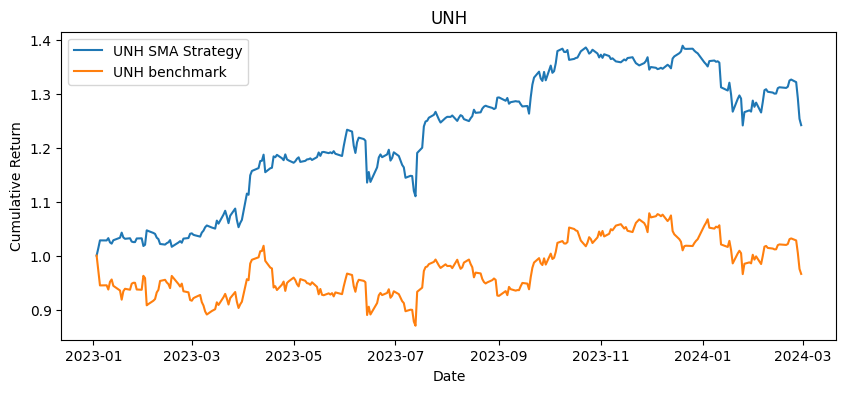

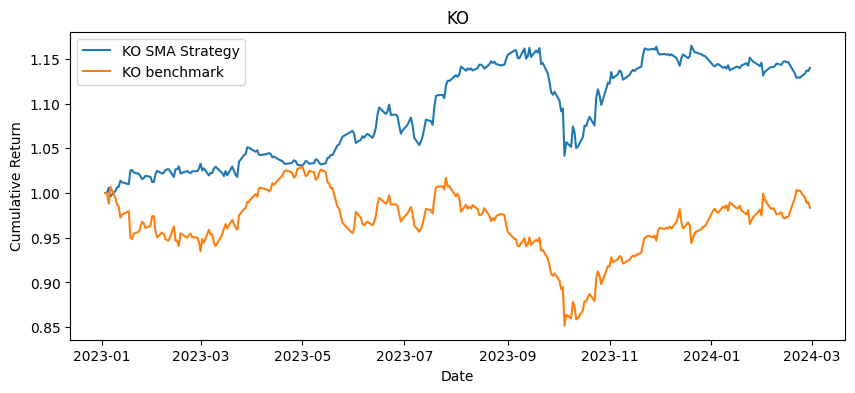

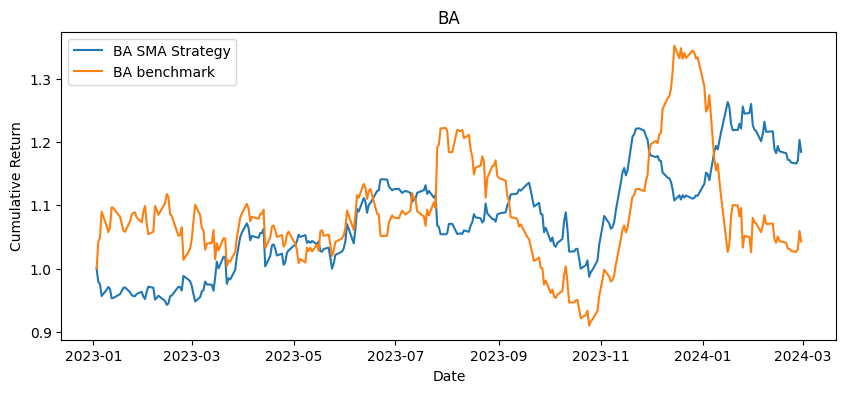

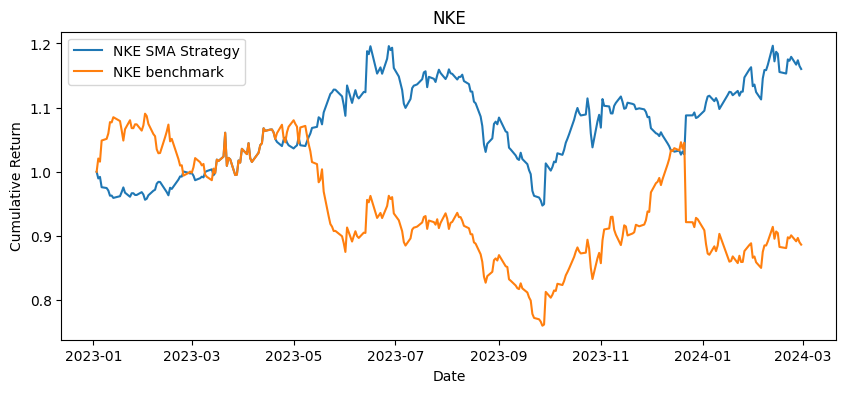

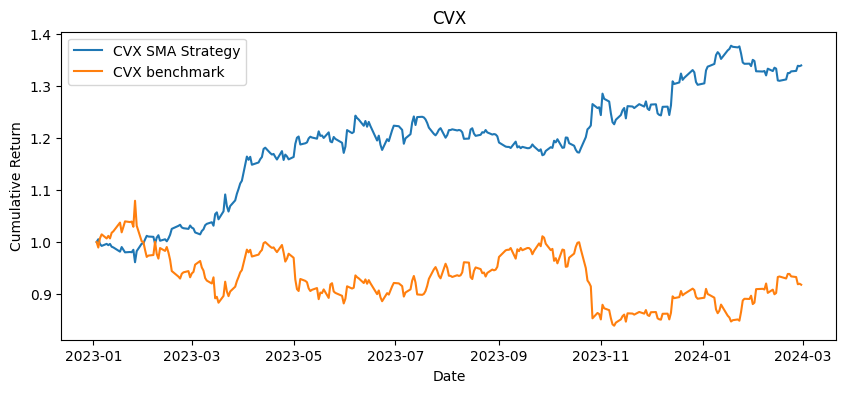

In [24]:
ret, signal = SMA(['MSFT', 'JNJ', 'MCD', 'NVDA', 'PFE', 'UNH', 'KO', 'BA', 'NKE', 'CVX'],close_prices, start_date='2023-01-01')
benchmark = get_benchmark(['MSFT', 'JNJ', 'MCD', 'NVDA', 'PFE', 'UNH', 'KO', 'BA', 'NKE', 'CVX'],close_prices, start_date='2023-01-01')
for ticker in ret.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(ret.index, ret[ticker], label=f"{ticker} SMA Strategy")
    plt.plot(benchmark.index,benchmark[ticker], label=f"{ticker} benchmark")
    plt.title(f"{ticker}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()

8 stocks were chosen for analysis using Machine Learning models (both classification and regression models). 4 stocks were selected that we think will perform best in the actual trading period

In [ ]:
# Machine Learning Regressions
data1 = np.log(close_prices/close_prices.shift(1)).dropna()
data1 = data1.loc[:,['MSFT', 'GOOGL','MCD', 'NVDA', 'BA','JNJ', 'XOM', 'KO']]

###########################################################################
#Lag 2 + Declare start date
sd = '2024-01-01'
lg = [1, 2]
# Predicted returns and total returns
LR_preds = LR_Training_Rolling_Returns(data1,lg,sd)
DT_preds = DT_Training_Rolling_Returns(data1,lg,sd)
SVC_preds = SVC_Training_Rolling_Returns(data1,lg,sd)
LR_preds_Sum = Training_Sum_returns(LR_preds)
DT_preds_Sum = Training_Sum_returns(DT_preds)
SVC_preds_Sum = Training_Sum_returns(SVC_preds)

# Merge all into 1 df, apply suffix
merged_df = pd.concat([LR_preds_Sum, DT_preds_Sum, SVC_preds_Sum], axis=1)
merged_df.columns = ['LinReg', 'DecisionTree', 'SVC' ]
styled_df_roll2 = merged_df.add_suffix('_Roll_2')
###########################################################################
#Lag 3
lg = [1, 2, 3]
# Predicted returns and total returns
LR_preds = LR_Training_Rolling_Returns(data1,lg,sd)
DT_preds = DT_Training_Rolling_Returns(data1,lg,sd)
SVC_preds = SVC_Training_Rolling_Returns(data1,lg,sd)
LR_preds_Sum = Training_Sum_returns(LR_preds)
DT_preds_Sum = Training_Sum_returns(DT_preds)
SVC_preds_Sum = Training_Sum_returns(SVC_preds)

# Merge all into 1 df, apply suffix
merged_df = pd.concat([LR_preds_Sum, DT_preds_Sum, SVC_preds_Sum], axis=1)
merged_df.columns = ['LinReg', 'DecisionTree', 'SVC' ]
styled_df_roll3 = merged_df.add_suffix('_Roll_3')

###########################################################################
# Concatenate them side by side with benchmarks
benchmarks = Training_benchmark(data1, start_date=sd)
merged_df = pd.concat([benchmarks,styled_df_roll2, styled_df_roll3], axis=1)
merged_df.rename(columns={merged_df.columns[0]: 'Benchmark'}, inplace=True)
merged_df

,Benchmark,LinReg_Roll_2,DecisionTree_Roll_2,SVC_Roll_2,LinReg_Roll_3,DecisionTree_Roll_3,SVC_Roll_3
Ticker,,,,,,,
MSFT,1.114391,1.076503,1.088919,1.114391,1.054631,1.078962,1.114391
GOOGL,0.995066,0.970044,0.934691,0.995066,0.962089,0.967591,0.995066
MCD,0.987366,1.044234,0.979943,0.987366,1.019745,1.067259,0.987366
NVDA,1.607944,1.554837,0.959701,1.607944,1.485052,1.238455,1.607944
BA,0.797406,0.730615,0.913058,0.797406,0.707600,0.856459,0.797406
JNJ,1.015544,0.993188,0.982950,1.007837,1.008055,0.974755,0.986149
XOM,1.027638,0.939734,0.933398,0.976280,0.884135,0.948227,0.961758
KO,1.002233,1.032186,1.032165,1.002233,1.033774,1.020994,1.002233


_____________

# Portfolio Returns

In [26]:
def get_portfolio_returns(close_df, start_date='2024-03-01'):
    ret , Sret = SMA(['BA', 'NKE', 'PFE', 'UNH','CVX','JNJ'],close_df, start_date=start_date)
    ret1, Sret1 = rolling_regression_predicted_returns(close_df,['KO'], lags=[1, 2,3], start_date=start_date)
    ret2, Sret2 = rolling_DTclassification_predicted_returns(close_df,['MCD'], lags=[1, 2,3], start_date=start_date)
    ret3, Sret3 = rolling_svc_predicted_returns(close_df,['MSFT','GOOGL'], lags=[1, 2, 3], start_date=start_date)
    
    combined_df_S = pd.concat([Sret,Sret1, Sret2, Sret3], axis=1)
    combined_df_cumret = pd.concat([ret,ret1, ret2, ret3], axis=1)
    combined_df_ret = close_df.loc[:,['BA', 'NKE', 'PFE', 'UNH','CVX','JNJ','KO','MCD','MSFT','GOOGL']]
    combined_df_ret = combined_df_ret.pct_change()
    combined_df_ret = combined_df_ret[combined_df_ret.index >= pd.to_datetime(start_date)]

    # simple returns
    returnss = combined_df_S*combined_df_ret

    return combined_df_cumret, returnss, combined_df_S

# Portfolio Optimisation using data from 2023-02-01

In [27]:

def calculate_sharpe_ratio(returnss):
    def min_Sharpe_ratio(w):
        return -(mu.T @ w)/np.sqrt(w.T @ (Q @ w))
    log_return = np.log(1 + returnss).dropna()
    mu = log_return.mean() * 252
    Q = log_return.cov() * 252


    w0 = [1./len(returnss.columns)] * len(returnss.columns)
    cons = ({'type': 'eq', 
            'fun': lambda w: np.sum(w) - 1})
    bnds = tuple((0.01, 1) for x in range(len(returnss.columns)))
    result = sco.minimize(min_Sharpe_ratio, w0, 
                        constraints = cons, 
                        bounds = bnds)
    weights = pd.Series(result.x, index=returnss.columns)
    print(f'maximum Sharpe ratio: {-result.fun}')
    print(f'Expected return: {mu.T @ weights}')
    print(f'weights: ')
    
    return weights

cum_ret, returnss, signals= get_portfolio_returns(close_prices, start_date='2023-02-01')
calculate_sharpe_ratio(returnss)


maximum Sharpe ratio: 1.9240222508805398
Expected return: 0.1683164723426264
weights: 


c:\Users\Jun Hao Ng\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Ticker
BA       0.105345
NKE      0.030862
PFE      0.010000
UNH      0.232653
CVX      0.290276
JNJ      0.123167
KO       0.010000
MCD      0.010000
MSFT     0.177697
GOOGL    0.010000
dtype: float64

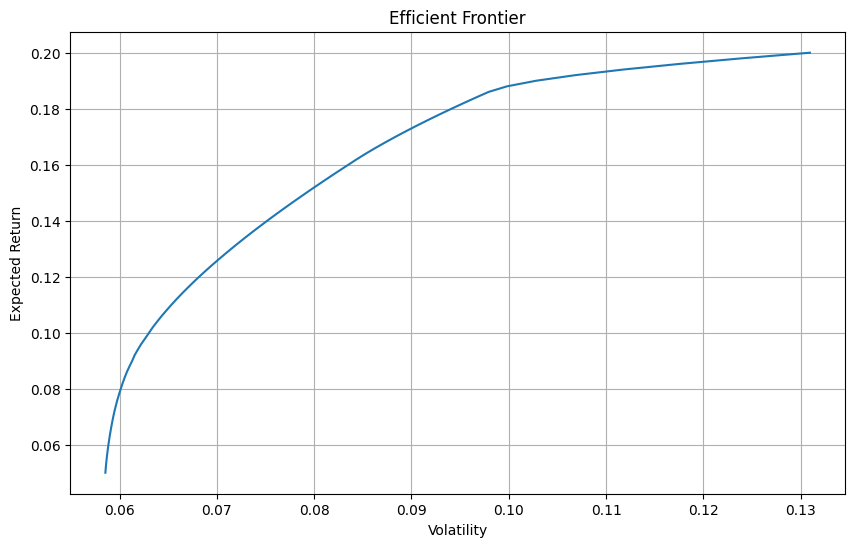

In [28]:

def plot_efficient_frontier(returnss):
    log_return = np.log(1 + returnss).dropna()
    mu = log_return.mean() * 252
    Q = log_return.cov() * 252

    w0 = [1./len(returnss.columns)] * len(returnss.columns)
    bnds = tuple((0.01, 1) for x in range(len(returnss.columns)))

    # Define the range of target returns
    R = np.arange(0.05, 0.2, 0.002)
    # obj func
    def min_var(w):
        return w.T @ (Q @ w)

    # initial guess

    # bound

    # initialize a list to store volatility values for different R
    vol_eff_front = []

    for r in R:
        # constraints
        cons = ({'type': 'eq', 
                'fun': lambda w: np.sum(w) - 1}, 
                {'type': 'eq', 
                'fun': lambda w: mu.T @ w - r})
        result = sco.minimize(min_var, w0, 
                            constraints = cons, 
                            bounds = bnds)
        vol_eff_front.append(math.sqrt(result['fun']))

    plt.figure(figsize=(10, 6))
    plt.plot(vol_eff_front, R)
    plt.xlabel('Volatility')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier')
    plt.grid()
    plt.show()

plot_efficient_frontier(returnss)

# Trading period

In [29]:
close_df = process_data('Trading_Project_Data.csv')
stocks = ['BA', 'NKE', 'PFE', 'UNH','CVX','JNJ','KO','MCD','MSFT','GOOGL']
start_date = '2024-03-01'
benchmark_df = close_df.loc[:,stocks]
benchmark_df = benchmark_df[benchmark_df.index >= start_date]
simple_ret = benchmark_df.pct_change()
cum_ret, _, signal = get_portfolio_returns(close_df, start_date=start_date)


# Graphs

c:\Users\Jun Hao Ng\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


maximum Sharpe ratio: 1.9240222508805398
Expected return: 0.1683164723426264
weights: 


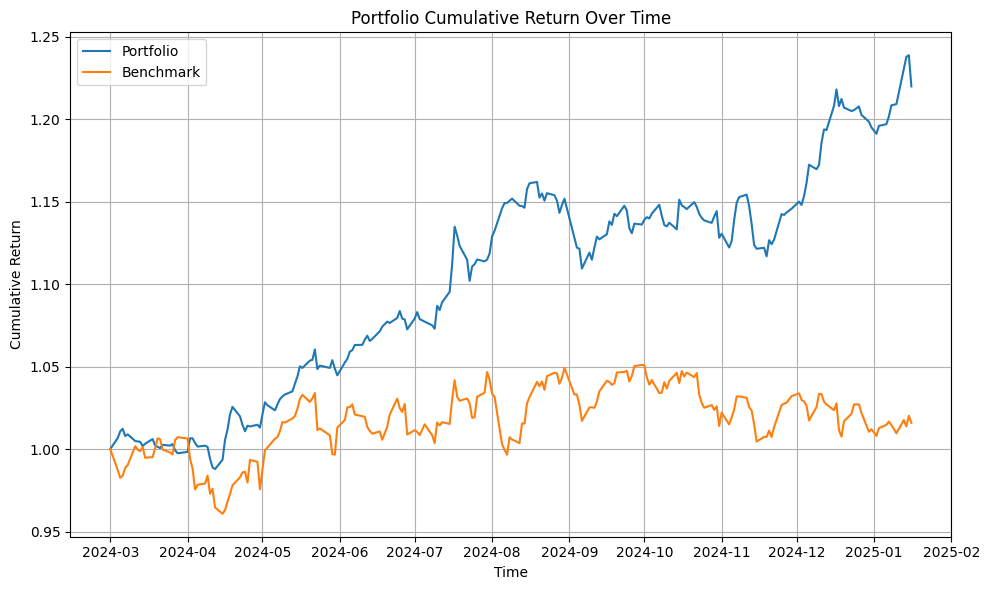

Final Portfolio Return: 1.2198288897762837
Final Benchmark Return: 1.01592573153948


In [30]:
def plot_final_return(combined_df, benchmark_df,weights):
    final_return = combined_df.tail(1)
    port_return = final_return@weights
    equal_weight = np.full(10,0.1)
    portfolio_returns = combined_df @ weights  # shape (T,)
    benchmark_df1 = benchmark_df / benchmark_df.iloc[0]
    benchmark_returns = benchmark_df1 @ equal_weight
    benchmark_final_return = benchmark_df1.tail(1) @ equal_weight
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_returns, label='Portfolio')
    plt.plot(benchmark_returns, label='Benchmark')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    plt.title('Portfolio Cumulative Return Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f'Final Portfolio Return: {port_return.values[0]}')
    print(f'Final Benchmark Return: {benchmark_final_return.values[0]}')

weights = calculate_sharpe_ratio(returnss)
plot_final_return(cum_ret, benchmark_df, weights)

maximum Sharpe ratio: 1.9240222508805398
Expected return: 0.1683164723426264
weights: 


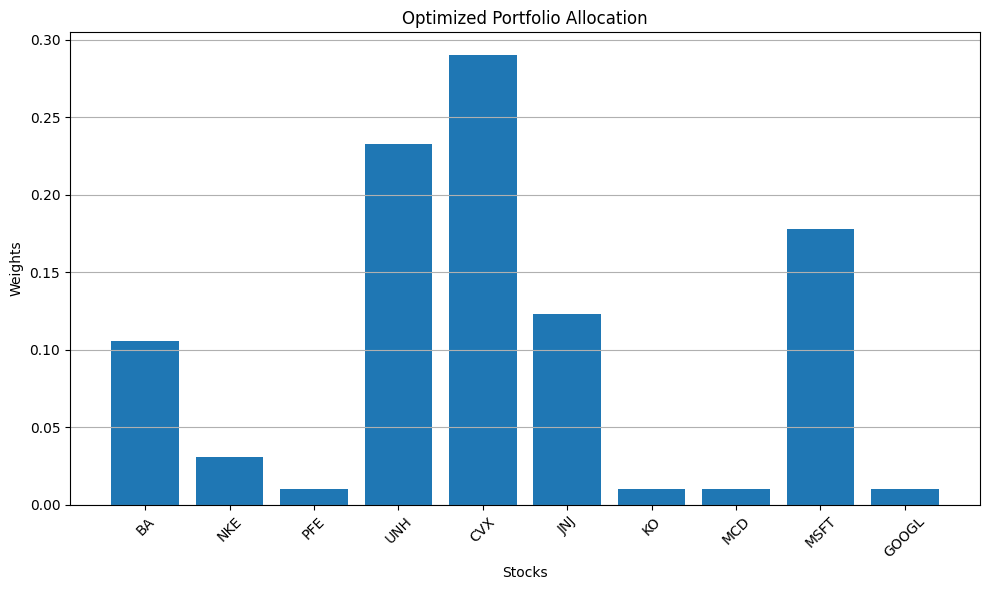

In [31]:

def plot_portfolio_allocation(weights):
    plt.figure(figsize=(10, 6))
    plt.bar(weights.index, weights.values)
    plt.xlabel('Stocks')
    plt.ylabel('Weights')
    plt.title('Optimized Portfolio Allocation')
    plt.xticks(rotation=45)  # Rotate labels if names are long
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

weights = calculate_sharpe_ratio(returnss)
plot_portfolio_allocation(weights)

# Performance of strategy for each stock

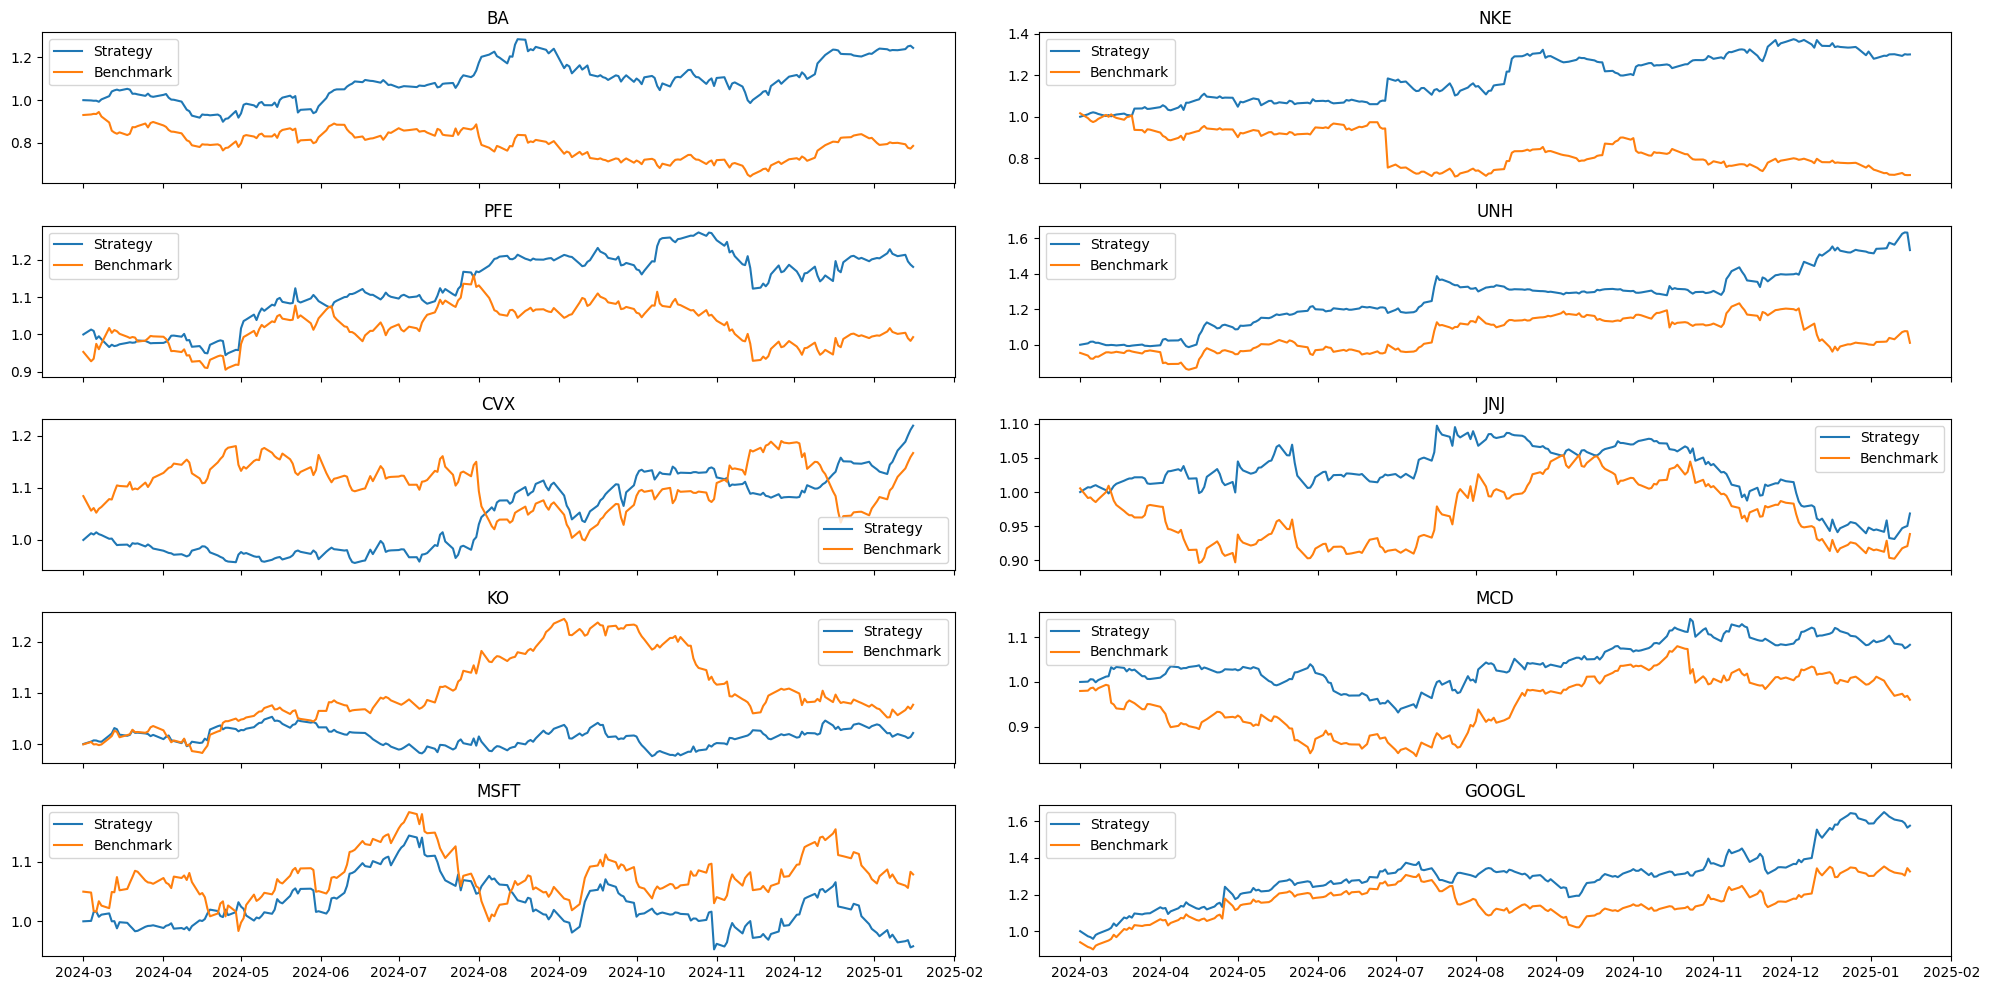

In [32]:
def individual_stock_analysis(cum_ret, benchmark_df):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 10), sharex=True)
    axes = axes.flatten()

    for i, col in enumerate(cum_ret.columns):
        axes[i].plot(cum_ret.index, cum_ret[col], label='Strategy')  # First line
        axes[i].plot(benchmark_df.index, benchmark_df[col], label= 'Benchmark')  # Second line
        axes[i].set_title(col)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

benchmark_df = get_benchmark(stocks, close_df, start_date='2024-03-01')
individual_stock_analysis(cum_ret, benchmark_df)

# Strategy Signals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

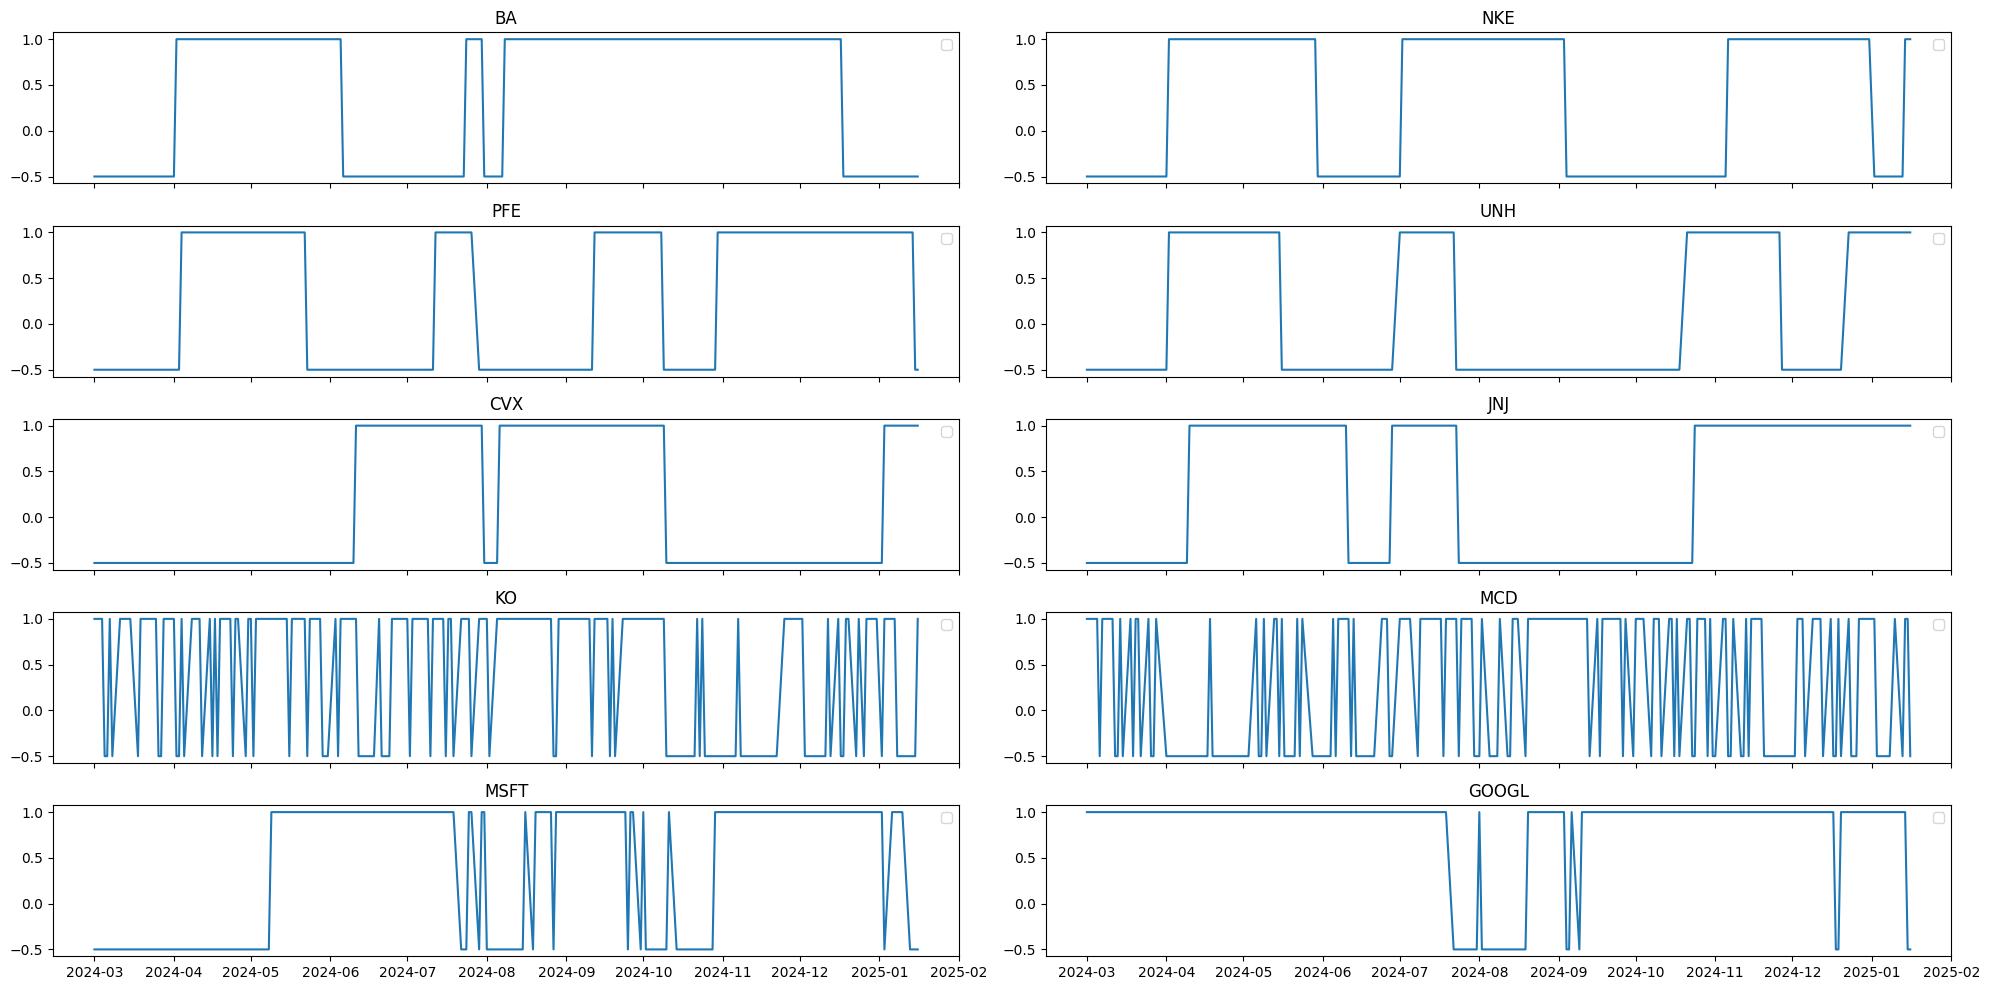

In [33]:
def plot_signals(signal):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for i, col in enumerate(signal.columns):
        axes[i].plot(signal.index, signal[col])
        axes[i].set_title(col)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_signals(signal)

In [34]:
def generate_portfolio_table(returns_df, weights, signals_df, initial_capital=50000):
    """
    Generate a portfolio tracking table that properly accounts for gains and losses over time.
    
    Parameters:
    ----------
    returns_df : DataFrame
        Dataframe containing simple returns for each stock (not cumulative)
    weights : Series or dict
        Portfolio weights for each stock
    signals_df : DataFrame
        Signals for each stock (-0.5 for short 0.5 unit, 1 for long 1 unit)
    initial_capital : float
        Initial investment amount
    
    Returns:
    -------
    DataFrame
        Portfolio tracking table with required columns
    """
    # Create a fresh dataframe with the same index as the returns
    result = pd.DataFrame(index=returns_df.index)
    
    # Add Date column
    result['Date'] = result.index
    
    # Get list of stocks
    stocks = list(weights.keys())
    
    # Initialize tracking columns
    for ticker in stocks:
        result[f'{ticker}_Position'] = 0.0
        result[f'{ticker}_Direction'] = 'CASH'
        result[f'{ticker}_Return'] = 0.0
    
    result['Long_Positions'] = 0.0
    result['Short_Positions'] = 0.0
    result['Cash'] = initial_capital
    result['Realized_PnL'] = 0.0
    result['Total_Portfolio_Value'] = initial_capital
    
    # Track shares and initial investment for each stock
    stock_units = {ticker: 0.0 for ticker in stocks}
    stock_initial_value = {ticker: 0.0 for ticker in stocks}
    total_portfolio_value = initial_capital
    
    # Process each date sequentially
    for i, date in enumerate(result.index):
        # Reset position totals for this date
        long_positions = 0.0
        short_positions = 0.0
        realized_pnl = 0.0
        
        if i == 0:
            # First day - establish initial positions based on weights and signals
            for ticker in stocks:
                signal = signals_df.loc[date, ticker]
                if signal != 0:
                    # Initial allocation for this stock
                    allocation = weights[ticker] * initial_capital
                    
                    # Adjust allocation based on signal strength
                    position_size = abs(signal) * allocation
                    
                    # Record position
                    result.loc[date, f'{ticker}_Position'] = position_size
                    stock_initial_value[ticker] = position_size
                    
                    if signal > 0:
                        result.loc[date, f'{ticker}_Direction'] = 'LONG'
                        long_positions += position_size
                    else:
                        result.loc[date, f'{ticker}_Direction'] = 'SHORT'
                        short_positions += position_size
            
            # Update totals for first day
            result.loc[date, 'Long_Positions'] = long_positions
            result.loc[date, 'Short_Positions'] = short_positions
            result.loc[date, 'Cash'] = initial_capital - long_positions - short_positions
            result.loc[date, 'Total_Portfolio_Value'] = long_positions + short_positions + result.loc[date, 'Cash']
        
        else:
            # Subsequent days - update positions based on returns and check for signal changes
            prev_date = result.index[i-1]
            
            for ticker in stocks:
                prev_signal = signals_df.loc[prev_date, ticker]
                current_signal = signals_df.loc[date, ticker]
                
                # Get daily return directly from returns dataframe
                daily_return = returns_df.loc[date, ticker]
                
                # Record the return
                result.loc[date, f'{ticker}_Return'] = daily_return
                
                # Update position value from previous day
                prev_position = result.loc[prev_date, f'{ticker}_Position']
                prev_direction = result.loc[prev_date, f'{ticker}_Direction']
                
                # Calculate new position value based on return
                if prev_direction == 'LONG':
                    new_position_value = prev_position * (1 + daily_return)
                elif prev_direction == 'SHORT':
                    new_position_value = prev_position * (1 - daily_return)  # Short profits when price falls
                else:
                    new_position_value = 0
                
                # Check if signal changed
                if current_signal != prev_signal:
                    # Signal changed - close previous position and open new one
                    
                    # If had a previous position, calculate P&L
                    if prev_position > 0:
                        # Record realized P&L from closing position
                        if prev_direction == 'LONG':
                            realized_pnl += (new_position_value - stock_initial_value[ticker])
                        else:  # SHORT
                            realized_pnl += (stock_initial_value[ticker] - new_position_value)
                    
                    # Reset tracking for this stock
                    stock_initial_value[ticker] = 0
                    
                    # Establish new position based on current signal
                    if current_signal != 0:
                        
                        # Calculate new position size
                        allocation = weights[ticker] * initial_capital
                        position_size = abs(current_signal) * allocation
                        
                        # Record new position
                        new_position_value = position_size
                        stock_initial_value[ticker] = position_size
                        
                        if current_signal > 0:
                            result.loc[date, f'{ticker}_Direction'] = 'LONG'
                        else:
                            result.loc[date, f'{ticker}_Direction'] = 'SHORT'
                    else:
                        result.loc[date, f'{ticker}_Direction'] = 'CASH'
                        new_position_value = 0
                else:
                    # Signal unchanged - keep same direction
                    result.loc[date, f'{ticker}_Direction'] = prev_direction
                
                # Store updated position value
                result.loc[date, f'{ticker}_Position'] = new_position_value
                
                # Add to position totals
                if result.loc[date, f'{ticker}_Direction'] == 'LONG':
                    long_positions += new_position_value
                elif result.loc[date, f'{ticker}_Direction'] == 'SHORT':
                    short_positions += new_position_value
            
            # Update totals for this date
            result.loc[date, 'Long_Positions'] = long_positions
            result.loc[date, 'Short_Positions'] = short_positions
            
            # Update realized P&L
            result.loc[date, 'Realized_PnL'] = result.loc[prev_date, 'Realized_PnL'] + realized_pnl
            
            # Cash increases by realized P&L and decreases by new positions
            result.loc[date, 'Cash'] = result.loc[prev_date, 'Cash'] + realized_pnl
            
            # Total portfolio value is sum of all positions and cash
            result.loc[date, 'Total_Portfolio_Value'] = long_positions + short_positions + result.loc[date, 'Cash']
    
    return result

In [35]:
portfolio_table = generate_portfolio_table(simple_ret, weights, signal, 50000)

# Core portfolio tracking table
display_columns = ['Date', 'Long_Positions', 'Short_Positions', 'Cash', 'Total_Portfolio_Value']
summary_table = portfolio_table[display_columns]

# For detailed position tracking
position_columns = ['Date'] + [f'{ticker}_Position' for ticker in weights.keys()] + [f'{ticker}_Direction' for ticker in weights.keys()]
positions_detail = portfolio_table[position_columns]
portfolio_table

,Date,BA_Position,BA_Direction,BA_Return,NKE_Position,NKE_Direction,NKE_Return,PFE_Position,PFE_Direction,PFE_Return,...,MSFT_Direction,MSFT_Return,GOOGL_Position,GOOGL_Direction,GOOGL_Return,Long_Positions,Short_Positions,Cash,Realized_PnL,Total_Portfolio_Value
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,2024-03-01,2633.616679,SHORT,0.000000,771.550092,SHORT,0.000000,250.000000,SHORT,0.000000,...,SHORT,0.000000,500.000000,LONG,0.000000,1500.000000,24250.000000,24250.000000,0.000000,50000.000000
2024-03-04,2024-03-04,2626.506003,SHORT,0.002700,789.271189,SHORT,-0.022968,256.581426,SHORT,-0.026326,...,SHORT,-0.001396,486.182074,LONG,-0.027636,1488.894932,24594.343250,24250.000000,0.000000,50333.238182
2024-03-05,2024-03-05,2618.647622,SHORT,0.002992,799.024090,SHORT,-0.012357,254.698442,SHORT,0.007339,...,SHORT,-0.029572,483.702829,LONG,-0.005099,986.815668,25044.772857,24249.916033,-0.083967,50281.504559
2024-03-06,2024-03-06,2620.470278,SHORT,-0.000696,804.550862,SHORT,-0.006917,243.858140,SHORT,0.042561,...,SHORT,-0.001391,479.072473,LONG,-0.009573,479.072473,25379.202219,24253.699484,3.699484,50111.974175
2024-03-07,2024-03-07,2594.004848,SHORT,0.010099,799.935959,SHORT,0.005736,247.445600,SHORT,-0.014711,...,SHORT,0.017533,489.937346,LONG,0.022679,1489.937346,24649.541729,24251.810672,1.810672,50391.289748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,2025-01-10,2636.649738,SHORT,0.001397,797.941196,SHORT,-0.001263,475.719290,LONG,-0.005212,...,LONG,-0.013214,501.645655,LONG,-0.009848,42560.963238,3687.183704,28502.877250,4252.877250,74751.024193
2025-01-13,2025-01-13,2658.570610,SHORT,-0.008314,788.078946,SHORT,0.012360,477.143598,LONG,0.002994,...,SHORT,-0.004201,498.955098,LONG,-0.005363,34137.818556,8389.279141,28283.846036,4033.846036,70810.943732
2025-01-14,2025-01-14,2713.902340,SHORT,-0.020813,1543.100185,LONG,-0.012625,470.200101,LONG,-0.014552,...,SHORT,-0.003643,495.428661,LONG,-0.007068,36392.956254,7421.134752,28255.560807,4005.560807,72069.651813


This documents the positions taken and the total portfolio value (which is more than the theoretical as the theoretical calculation did not consider the cash portion reserved for shorting)

# Using this code for future data

In [36]:
# DO NOT CHANGE
stocks = ['BA', 'NKE', 'PFE', 'UNH','CVX','JNJ','KO','MCD','MSFT','GOOGL']
start_date = '2024-03-01'
cum_ret, returnss, signal = get_portfolio_returns(close_df, start_date=start_date)

new_weights = calculate_sharpe_ratio(returnss)

maximum Sharpe ratio: 3.0883616838682055
Expected return: 0.26957727651580454
weights: 


c:\Users\Jun Hao Ng\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


# Change and Run following cell for additional data

In [37]:
# Change file path
data = process_data('extra_data.csv')
# Change start_date
start_date = '2025-01-17'
combined_df = pd.concat([close_df, data])
benchmark_df = combined_df.loc[:,stocks]
benchmark_df = benchmark_df[benchmark_df.index >= start_date]
simple_ret = benchmark_df.pct_change()
cum_ret, _, signal = get_portfolio_returns(combined_df, start_date=start_date)
plot_final_return(cum_ret, benchmark_df, weights)
plot_portfolio_allocation(weights)
benchmark_ret = get_benchmark(stocks, combined_df, start_date=start_date)
individual_stock_analysis(cum_ret, benchmark_ret)
plot_signals(signal)
portfolio_table = generate_portfolio_table(simple_ret, weights, signal, 50000)

# Core portfolio tracking table
display_columns = ['Date', 'Long_Positions', 'Short_Positions', 'Cash', 'Total_Portfolio_Value']
summary_table = portfolio_table[display_columns]

# For detailed position tracking
position_columns = ['Date'] + [f'{ticker}_Position' for ticker in weights.keys()] + [f'{ticker}_Direction' for ticker in weights.keys()]
positions_detail = portfolio_table[position_columns]
portfolio_table

FileNotFoundError: [Errno 2] No such file or directory: 'extra_data.csv'